#Using machine learning techniques to predict compressional travel-time (DTC) in an offset well
    
 Purpose: Predicting acoustic slowness data from triple compbo logs based on ML model that was built on offset well                       logging data. SB16 well is used to build ML model. The model is then deployed to predict slowness data in SB17                 offsett well.
          This section includes data exploring, cleaning, correcting, completing, creating, converting, and deploying ML                 technique. 
 
 Data: The data used is available at https://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WELLIDX.HTM
       Provided data is part of the USGS Open File Report 00-200 public dataset.
             
             
 Tools: Python, Jupyter Notebook, Pandas, Numpy, Lasio, Seaborn, Xgboost
 
 Improvements: Outlier Detection, ML Hyper parameter optimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import lasio
import pandas as pd
import numpy as np

In [2]:
las = lasio.read("SB16.las")

In [3]:
log = las.df() #integration w/ pandas

In [4]:
logs = log[['DT', 'NPHI', 'CALI', 'GR', 'RHOB']]

In [5]:
logs = logs.reset_index()
logs=logs.rename(columns=({'M__DEPTH':'DEPT'}))
logs=logs.rename(columns=({'DT':'DTC'}))

In [6]:
logs = logs.dropna()
#dropping nan values is necessary for ML model building

In [7]:
print (logs.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718 entries, 2883 to 4600
Data columns (total 6 columns):
DEPT    1718 non-null float64
DTC     1718 non-null float64
NPHI    1718 non-null float64
CALI    1718 non-null float64
GR      1718 non-null float64
RHOB    1718 non-null float64
dtypes: float64(6)
memory usage: 94.0 KB
None


In [8]:
logs.isnull().any()


DEPT    False
DTC     False
NPHI    False
CALI    False
GR      False
RHOB    False
dtype: bool

In [9]:
logs.head()

,DEPT,DTC,NPHI,CALI,GR,RHOB
2883,1519.5,91.7468,35.2721,8.2083,67.1958,2.4139
2884,1520.0,93.1566,34.6705,8.2148,65.3884,2.4232
2885,1520.5,94.9263,34.0639,8.2477,64.2851,2.4356
2886,1521.0,96.3718,33.4030,8.2655,64.0430,2.4519
2887,1521.5,95.5853,32.9318,8.2750,64.3847,2.4586


In [10]:
def plot(logs):
    #to make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPT')
    
    ltop=logs.DEPT.min(); lbot=logs.DEPT.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs.GR, logs.DEPT, '-g')
    ax[1].plot(logs.CALI, logs.DEPT, '-')
    ax[2].plot(logs.DTC, logs.DEPT, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.DEPT, '-', color='r')
    ax[4].plot(logs.NPHI, logs.DEPT, '-', color='blue')
    
        
    for i in range(len(ax)):
        ax[i].set_ylim(ltop,lbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("CALI")
    ax[1].set_xlim(6,16)
    ax[2].set_xlabel("DTC")
    ax[2].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("NPHI")
    ax[4].set_xlim(logs.NPHI.min(),logs.NPHI.max())

    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])


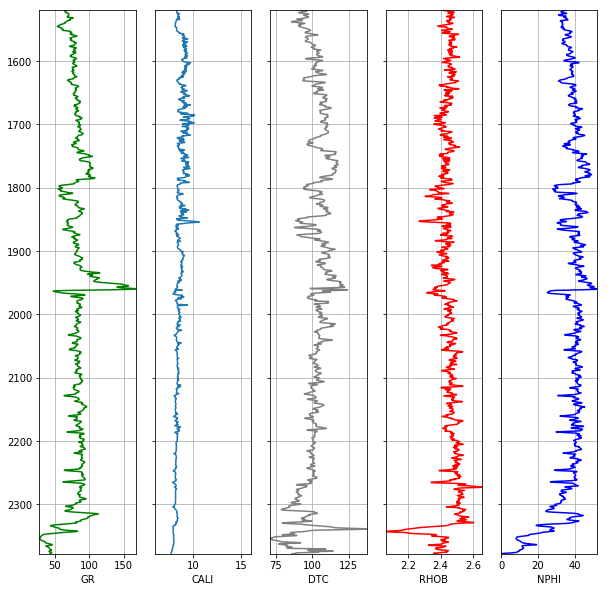

In [11]:
plot(logs)

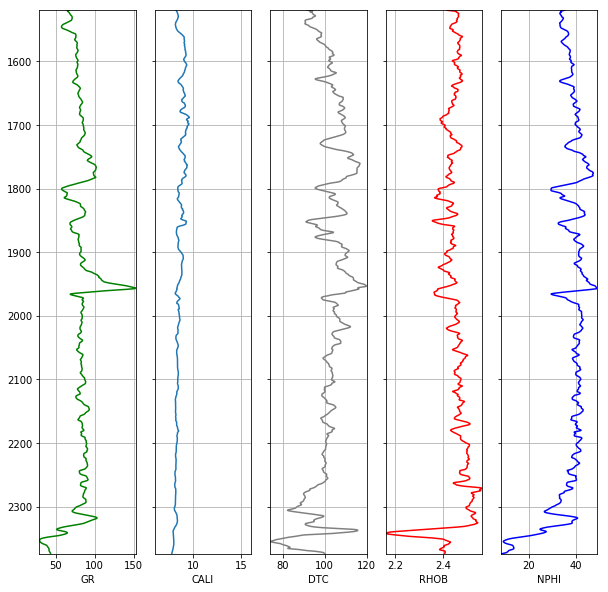

In [12]:
#Despiking logs - Improves model accuarrcy and predictions
loglst = list(logs)

logs = logs.copy(deep=True)
window = 17
for i in loglst:
    logs[i] = pd.Series(logs[i]).rolling(window=window, min_periods=1).mean()

#plotting after despking
plot(logs)

In [13]:
import seaborn as sns

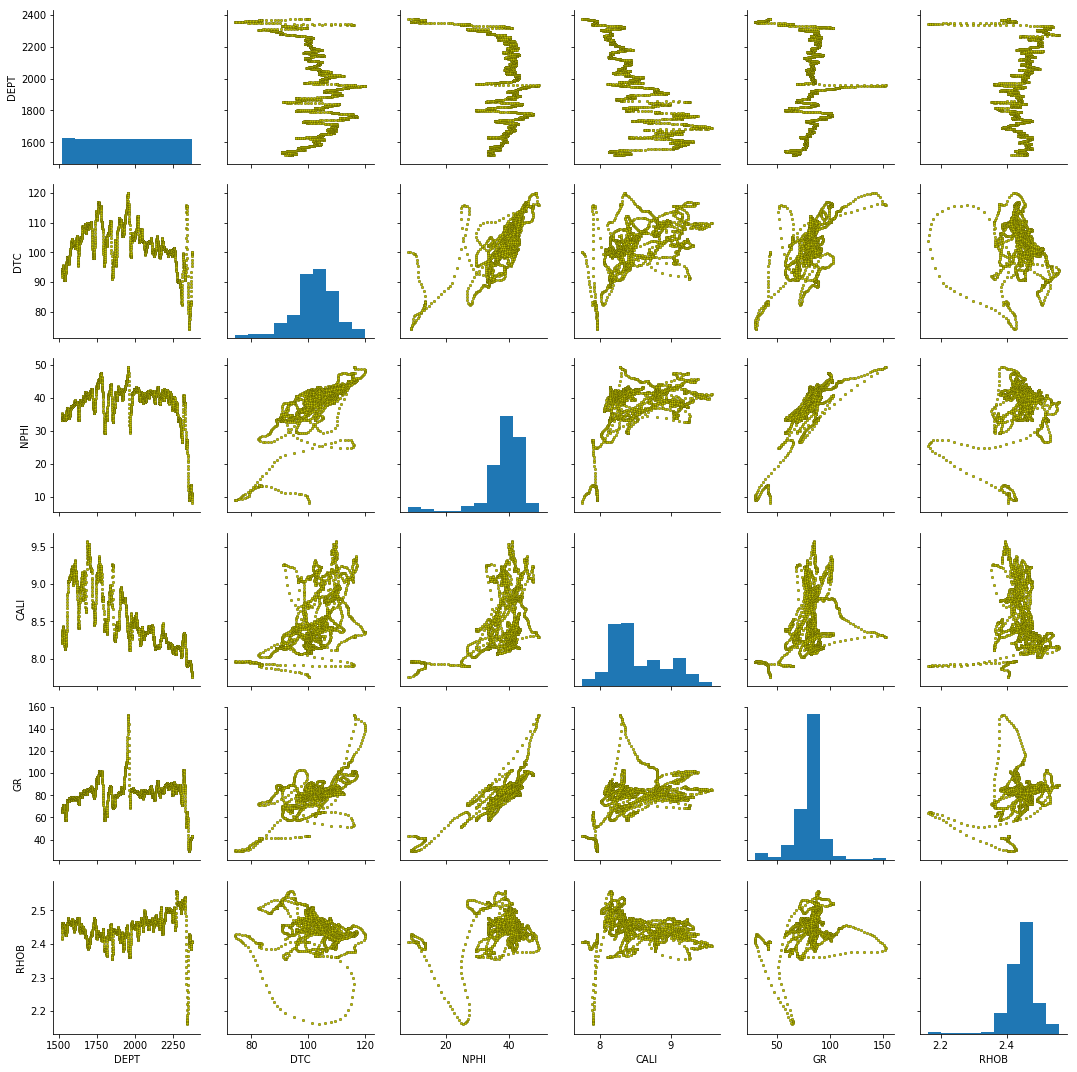

In [14]:
g = sns.PairGrid(logs)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=8, color = "y", edgecolor="k", linewidth= 0.2);

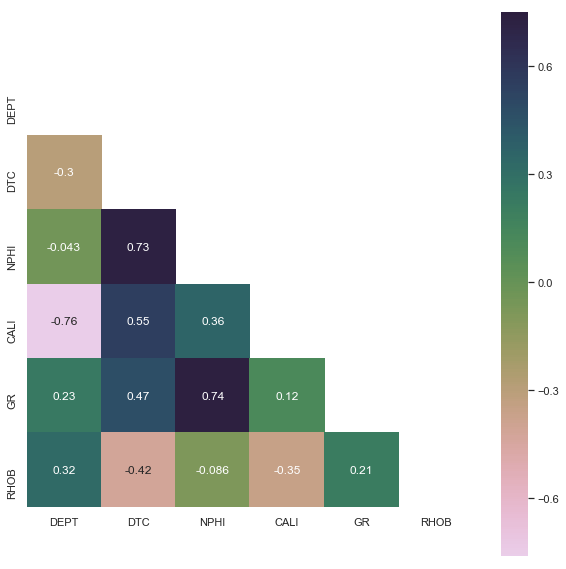

In [15]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(logs.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

plt.subplots(figsize=(10,10))

# Draw the heatmap (spearman corrected) with the mask and correct aspect ratio
sns.heatmap(logs.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=0.75, square=True)

plt.show()

In [16]:
features = ['GR','CALI', 'NPHI', 'RHOB']
Target = ['DTC']

X=logs[features]
y=logs[Target]

In [17]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


In [18]:
#Train Test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
XGB_model = XGBRegressor()
XGB_model.fit(train_X, train_y, verbose=False)
DTC_P = XGB_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(DTC_P, test_y)))

[14:32:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 1.5956487389297342


In [19]:
#Add model results to dataframe using entire data
XGB_model = XGBRegressor()
XGB_model.fit(X, y, verbose=False)
DTC_XGB = XGB_model.predict(X)
logs['DTC_XGB'] = DTC_XGB
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_XGB, y)))

[14:32:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 1.361829027090966


C:\Users\pc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


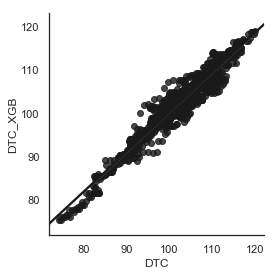

In [20]:
g = sns.PairGrid(logs, y_vars=["DTC_XGB"], x_vars=["DTC"], size=4)
g.map(sns.regplot, color="0.1")
plt.show()

C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


KeyError: 'DTC_Out'

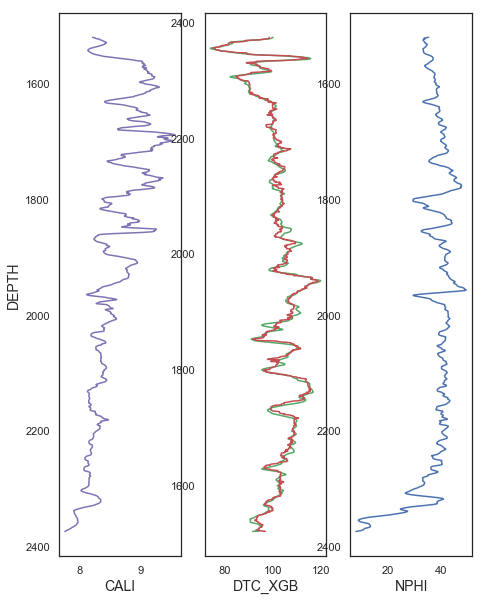

In [21]:
#Plotting Insample results
fig = plt.figure(figsize=(10, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(logs['CALI'], logs['DEPT'], color = 'm', alpha=1)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('CALI', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax2.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(1, 4, 2)
ax3.plot(logs['DTC_XGB'], logs['DEPT'], color = 'r', alpha=1)
ax3.set_xlabel('DTC_XGB', fontsize = '14')
plt.gca().invert_yaxis()

ax4 = fig.add_subplot(1, 4, 3)
ax4.plot(logs['NPHI'], logs['DEPT'], color = 'b', alpha=1)
ax4.set_xlabel('NPHI', fontsize = '14')
plt.gca().invert_yaxis()

ax5 = fig.add_subplot(1, 4, 1)
ax5.plot(logs['DTC_Out'], logs['DEPT'], color = 'k', alpha=1)
ax5.set_xlabel('DTC_Out', fontsize = '14')
plt.gca().invert_yaxis()

plt.show()


In [ ]:
# linreg model 
# iterate over possible number of cross validation folds to check scores and decide optimal fold 
from sklearn.linear_model import LinearRegression

Linreg = LinearRegression()

scorelinreg = []
for i in np.arange(2, 15, 1):
    score = cross_val_score(Linreg, X, y, cv=i)
    scorelinreg.append(np.mean(score))
    # Take the mean of the scores (because we have one for each fold)

print (scorelinreg)

In [ ]:
Linreg.fit(X, y)
DTC_Lin = Linreg.predict(X)
logs['DTC_Lin'] = DTC_Lin
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_Lin, y)))

In [ ]:
logs.head()

In [ ]:
fig = plt.figure(figsize=(10, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(logs['CALI'], logs['DEPT'], color = 'm', alpha=1)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('CALI', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax2.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()


ax3 = fig.add_subplot(1, 4, 2)
ax3.plot(logs['DTC_XGB'], logs['DEPT'], color = 'r', alpha=1)
ax3.set_xlabel('DTC_XGB', fontsize = '14')

ax4 = fig.add_subplot(1, 4, 3)
ax4.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax4.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()

ax5 = fig.add_subplot(1, 4, 3)
ax5.plot(logs['DTC_Lin'], logs['DEPT'], color = 'k', alpha=1)
ax5.set_xlabel('DTC_Lin', fontsize = '14')

plt.show()

In [ ]:
def error_flag(pred, actual, dev = 1.0, method = 1):
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

In [ ]:
from matplotlib  import gridspec

flag = error_flag(logs["DTC_XGB"], logs["DTC"], 1,  1)


fig = plt.figure(figsize=(5,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'DEPTH   $(f)$', size=15)
ax.fill_betweenx(logs['DEPT'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=15)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs["DTC_XGB"], logs["DEPT"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs["DTC"], logs["DEPT"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs['DEPT'], logs["DTC_XGB"], logs["DTC"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DTC vs DTC_XGB', size=15)

ax1.legend()
    
ax1.grid()
plt.show()

In [ ]:
#Apply model to the offset well to predict DT 
las2 = lasio.read("SB17.las")
logs2 = las2.df()

In [ ]:
logs2.head()

In [ ]:
logs2.describe()

In [ ]:
logs2 = logs2[['DT', 'NPHI', 'CALI', 'GR', 'RHOB']]

In [ ]:
logs2 = logs2.reset_index()
logs2 =logs2.rename(columns=({'M__DEPTH':'DEPT'}))
logs2=logs2.rename(columns=({'DT':'DTC'}))

In [ ]:
logs2 = logs2.dropna()
logs2.isnull().any()

In [ ]:
#Despiking logs - Improves model accuarrcy and predictions
loglst2 = list(logs2)

logs2 = logs2.copy(deep=True)
window = 17
for i in loglst2:
    logs2[i] = pd.Series(logs2[i]).rolling(window=window, min_periods=1).mean()

In [ ]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(logs2.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

plt.subplots(figsize=(10,10))

# Draw the heatmap (spearman corrected) with the mask and correct aspect ratio
sns.heatmap(logs2.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=0.75, square=True)

plt.show()

In [ ]:
def plot(logs2):
    #make sure logs are sorted by depth
    logs2 = logs2.sort_values(by='DEPT')
    
    ltop=logs2.DEPT.min(); lbot=logs2.DEPT.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs2.GR, logs2.DEPT, '-g')
    ax[1].plot(logs2.CALI, logs2.DEPT, '-')
    ax[2].plot(logs2.DTC, logs2.DEPT, '-', color='0.5')
    ax[3].plot(logs2.RHOB, logs2.DEPT, '-', color='r')
    ax[4].plot(logs2.NPHI, logs2.DEPT, '-', color='blue')
    
        
    for i in range(len(ax)):
        ax[i].set_ylim(ltop,lbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs2.GR.min(),logs2.GR.max())
    ax[1].set_xlabel("CALI")
    ax[1].set_xlim(6,16)
    ax[2].set_xlabel("DTC")
    ax[2].set_xlim(logs2.DTC.min(),logs2.DTC.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs2.RHOB.min(),logs2.RHOB.max())
    ax[4].set_xlabel("NPHI")
    ax[4].set_xlim(logs2.NPHI.min(),logs2.NPHI.max())

    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
plot(logs2)

In [ ]:
features2 = ['GR', 'CALI', 'NPHI', 'RHOB']
Target2 = ['DTC']

X2=logs2[features2]
y2=logs2[Target2]

In [ ]:
DTC_XGB2 = XGB_model.predict(X2)
logs2['DTC_XGB2'] = DTC_XGB2
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_XGB2, y2)))

In [ ]:
g = sns.PairGrid(logs2, y_vars=["DTC_XGB2"], x_vars=["DTC"], height=4)
g.map(sns.regplot, color="0.1")
plt.show()

In [ ]:
flag = error_flag(logs2["DTC_XGB2"], logs2["DTC"], 1,  1)


fig = plt.figure(figsize=(5,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'DEPTH   $(f)$', size=15)
ax.fill_betweenx(logs2['DEPT'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=15)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["DTC_XGB2"], logs2["DEPT"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["DTC"], logs2["DEPT"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPT'], logs2["DTC_XGB2"], logs2["DTC"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DTC vs DTC_XGB2', size=15)

ax1.legend()
    
ax1.grid()
plt.show()